<a href="https://colab.research.google.com/github/ge-a/cs4100final/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The saved model parameters can be viewed in this Google Drive. Each model has been trained on 200,000 parameters using the code below.
- https://drive.google.com/drive/folders/1eomS6hPnoLsxTZ3T37TRINz6e9oEjdCT?usp=sharing

In [ ]:
# install box2d for gym
!pip install swig > /dev/null 2>&1
!pip install gym[box2d] > /dev/null 2>&1

# install stable-baselines3 for RL models
!pip install stable-baselines3 > /dev/null 2>&1
!pip install 'shimmy>=0.2.1' > /dev/null 2>&1

In [ ]:
import gym
import time
import warnings
import subprocess
import numpy as np
from tqdm import tqdm
from typing import Callable
from google.colab import files
from gym.wrappers import RecordVideo
from stable_baselines3 import (
    PPO, # Proximal Policy Optimization
    A2C, # Advantage Actor Critic
    DDPG, # Deep Deterministic Policy Gradient
    SAC, # Soft Actor Critic
)
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.noise import NormalActionNoise

In [ ]:
# Train or load a `stable_baselines3` RL model that supports Space.Box
# NOTE: Model will be trained if `load_file` is not provided
def run(
        video_folder: str,
        model: Callable,
        policy='CnnPolicy',
        load_file=None,
        train_name=None,
        timesteps=100_000,
        download=False,
        **kwargs,
    ):
    warnings.filterwarnings('ignore')
    subprocess.run(['rm', '-rf', video_folder])

    # initialize 'CarRacing-v2' environment
    env = gym.make(
        'CarRacing-v2',
        new_step_api=True,
        lap_complete_percent=50,
        max_episode_steps=2048,
    )
    env = RecordVideo(
        env,
        video_folder=f'./{video_folder}',
        new_step_api=True,
        episode_trigger=lambda episode: True,
    )
    vec_env = make_vec_env('CarRacing-v2', n_envs=1) # only needed for training

    # load or train RL model
    if load_file:
        m = model.load(load_file, env=vec_env)
        print('Model loaded')
    else:
        print('Model training...')
        m = model(policy, vec_env, verbose=0, **kwargs)
        m.learn(total_timesteps=timesteps, progress_bar=True)
        m.save(train_name)
        print('Model trained')
        if download:
            time.sleep(2)
            files.download(f'{train_name}.zip')

    return env, m


# Evaluate multiple episodes for a given environment and RL model
def eval(
        env, m,
        n_episodes=10,
        n_timesteps=5000,
        reward_threshold=False
    ):
    # Initiate variables for tracking best episode and rewards
    best_episode = -1
    highest_reward = float('-inf')
    total_reward = 0
    rewards = [[] for _ in range(n_episodes)]
    try:
        # Run the model for the number of episodes
        for ep_id in range(n_episodes):
            obs = env.reset()
            ep_reward = 0
            # Run evironment for the number of timesteps, keeping track of reward
            for _ in tqdm(range(n_timesteps), desc=f'Episode #{ep_id}', unit='steps'):
                action, _states = m.predict(obs)
                obs, reward, done, truncated, info = env.step(action)
                ep_reward += reward
                rewards[ep_id].append(ep_reward)
                if done:
                    break

            # Track the highest reward
            ep_reward = round(ep_reward)
            total_reward += ep_reward
            if ep_reward > highest_reward:
                highest_reward = ep_reward
                best_episode = ep_id

            # Break if we have met the reward threshold
            if reward_threshold and highest_reward > reward_threshold:
                break

        # Output average reward and best episodes
        print('\nAverage reward:', round(total_reward / n_episodes))
        print(f'Best episode: {best_episode} ({highest_reward})')
        return rewards
    # Ensure the environment is properly closed at termination
    finally:
        env.close()

# Model 1: PPO (Proximal Policy Optimization)

In [ ]:
# Policy: stablebaselines-3 CNN

load = True
video_folder = 'ppo_video'
model = PPO
if load:
    env, m = run(
        video_folder=video_folder,
        model=model,
        load_file='ppo_carracing_200k',
    )
else:
    train_name = 'ppo_carracing_100k'
    ppo_kwargs = {
        'learning_rate': 0.0003,
        'n_steps': 2048,
        'batch_size': 64,
        'n_epochs': 10,
        'gamma': 0.99,
        'gae_lambda': 0.95,
        'ent_coef': 0.0,
        'vf_coef': 0.5,
    }
    env, m = run(
        video_folder=video_folder,
        model=model,
        train_name=train_name,
        timesteps=200_000,
        download=True,
        **ppo_kwargs
    )

In [ ]:
rewards = eval(
    env, m,
    n_episodes=20,
    n_timesteps=2048,
    reward_threshold=800,
)

In [ ]:
# Policy: stablebaselines-3 CNN

load = True
video_folder = 'ppo_video'
model = PPO
if load:
    env, m = run(
        video_folder=video_folder,
        model=model,
        load_file='ppo_carracing_100k',
    )
else:
    train_name = 'ppo_carracing_100k'
    ppo_kwargs = {
        'learning_rate': 0.0003,
        'n_steps': 2048,
        'batch_size': 64,
        'n_epochs': 10,
        'gamma': 0.99,
        'gae_lambda': 0.95,
        'ent_coef': 0.0,
        'vf_coef': 0.5,
    }
    env, m = run(
        video_folder=video_folder,
        model=model,
        train_name=train_name,
        timesteps=200_000,
        download=True,
        **ppo_kwargs
    )


Model loaded


In [ ]:
rewards = eval(
env, m,
n_episodes=10,
n_timesteps=2048,
reward_threshold=800,
)

# Model 2: A2C (Advantage Actor Critic)

In [ ]:
# Policy: stablebaselines-3 CNN

load = True
video_folder = 'a2c_video'
model = A2C
if load:
    env, m = run(
        video_folder=video_folder,
        model=model,
        load_file='a2c_carracing_100k',
    )
else:
    train_name = 'a2c_carracing_100k'
    a2c_kwargs = {
        'learning_rate': 0.0007,
        'n_steps': 5,
        'gamma': 0.99,
        'gae_lambda': 1.0,
        'ent_coef': 0.0,
        'vf_coef': 0.5,
        'use_rms_prop': True,
    }
    env, m = run(
        video_folder=video_folder,
        model=model,
        train_name=train_name,
        timesteps=10_000,
        download=True,
        **a2c_kwargs
    )

Model loaded


In [ ]:
eval(
    env, m,
    n_episodes=3,
    n_timesteps=1000,
    reward_threshold=500,
)

Episode #2: 100%|██████████| 1000/1000 [00:13<00:00, 75.28steps/s]


Average reward: -84
Best episode: 1 (-83)


# Model 3: DDPG (Deep Deterministic Policy Gradient)

In [ ]:
# Policy: CNN
# things to try: action noise or changing the policy

load = True
video_folder = 'ddpg_video'
model = DDPG
if load:
    env, m = run(
        video_folder=video_folder,
        model=model,
        load_file='ddpg_carracing_100k',
    )
else:
    train_name = 'ddpg_carracing_100k'
    env, m = run(
        video_folder=video_folder,
        model=model,
        train_name=train_name,
        timesteps=100_000,
        download=True,
    )

Model loaded


In [ ]:
eval(
    env, m,
    n_episodes=3,
    n_timesteps=1000,
    reward_threshold=500,
)

Episode #2: 100%|██████████| 1000/1000 [00:12<00:00, 81.25steps/s]


Average reward: -93
Best episode: 0 (-93)


# Model 4: SAC (Soft Actor Critic)

In [ ]:
# Policy: stablebaselines-3 CNN

load = True
video_folder = 'sac_video'
model = SAC
if load:
    env, m = run(
        video_folder=video_folder,
        model=model,
        load_file='sac_carracing_100k',
    )
else:
    train_name = 'sac_carracing_100k'
    sac_kwargs = {
        'learning_rate': 0.0003,
        'learning_starts': 100,
        'batch_size': 256,
        'tau': 0.005,
        'gamma': 0.99,
    }
    env, m = run(
        video_folder=video_folder,
        model=model,
        train_name=train_name,
        timesteps=100_000,
        download=True,
        **sac_kwargs
    )

In [ ]:
eval(
    env, m,
    n_episodes=3,
    n_timesteps=1000,
    reward_threshold=500,
)

Episode #2: 100%|██████████| 1000/1000 [00:13<00:00, 75.53steps/s]


Average reward: -19
Best episode: 0 (14)


# Custom PPO Policy

In [ ]:
import torch
import torch.nn as nn

# Policy as a class for visualization
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Define batch normalization layers
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        # Define max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Define fully connected layer
        self.fc = nn.Linear(64 * 12 * 12, 64)  # Adjust the output size as needed

    def forward(self, x):
        # Convolutional layers with batch normalization and ReLU activation
        x = self.pool(self.bn1(nn.ReLU()(self.conv1(x))))
        x = self.pool(self.bn2(nn.ReLU()(self.conv2(x))))
        x = self.pool(self.bn3(nn.ReLU()(self.conv3(x))))
        # Flatten the output for fully connected layers
        x = x.view(-1, 64 * 12 * 12)  # Adjust the size accordingly
        # Fully connected layer
        x = self.fc(x)
        return x

In [ ]:
# Save policy to be loaded freely
cnn = CNN()
torch.save(cnn.state_dict(), 'model.pth')

In [ ]:
# number of parameters using custom CNN policy
cnn = CNN()
params = sum([n.numel() for n in cnn.parameters() if n.requires_grad])
params

613696

In [ ]:
!pip install torchview > /dev/null 2>&1

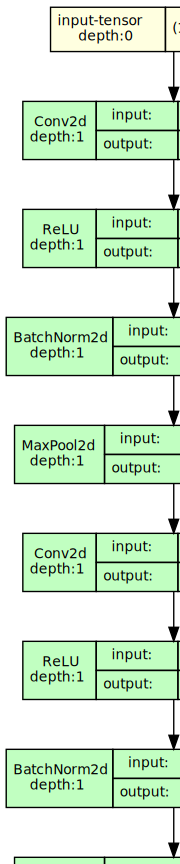

In [ ]:
# Policy Visualization for Slideshow and paper
from torchview import draw_graph

cnn = CNN()
graph = draw_graph(
    model=cnn,
    input_size=(1, 3, 96, 96),
    save_graph=True,
)
graph.visual_graph

In [ ]:
!pip install hiddenlayer > /dev/null 2>&1

In [ ]:
import torch as th
import torch.nn as nn
from gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# Custom policy class, inherits BaseFeaturesExtractor from stablebaselines3
class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: spaces.Box, features_dim: int = 256):
        super().__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

# define args for stable baselines 3
policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)

video_folder = 'videos'

# set up environment for recording
env = gym.make(
    'CarRacing-v2',
    new_step_api=True,
    lap_complete_percent=50,
    max_episode_steps=5000,
)
env = RecordVideo(
    env,
    video_folder=f'./{video_folder}',
    new_step_api=True,
    episode_trigger = lambda episode: True
)

vec_env = make_vec_env('CarRacing-v2', n_envs=1) # only needed for training

train_name = 'ppo_carracing_200k'

# train policy
model = PPO("CnnPolicy", vec_env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(200_000, progress_bar=True)
model.save(train_name)


In [ ]:
# Evaluate model for 50 episodes
rewards = eval(
    env, model,
    n_episodes=50,
    n_timesteps=102400,
    reward_threshold=800,
)

In [ ]:
import matplotlib.pyplot as plt

# average reward across test trials
min_length = len(rewards[18]) - 10
clipped_reward = [sublist[:min_length] for sublist in rewards]
transposed_clipped_reward = list(zip(*clipped_reward))
average_rewards = [sum(column) / len(column) for column in transposed_clipped_reward]

# plot the reward
plt.plot(range(len(average_rewards)), average_rewards)
plt.xlabel('Timestep')
plt.ylabel('Total Reward (Avg. over Test Trials)')
plt.title('Reward over Time - Custom Policy')
plt.show()